In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.19.6'

#### Fetch datasets in Zarr format

In [2]:
scarf.fetch_dataset(
    dataset_name='kang_15K_pbmc_rnaseq',
    save_path='scarf_datasets',
    as_zarr=True
)

scarf.fetch_dataset(
    dataset_name='kang_14K_ifnb-pbmc_rnaseq',
    save_path='scarf_datasets',
    as_zarr=True
)

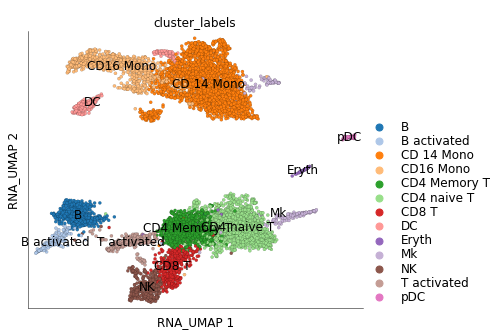

In [3]:
# Control/untreated PBMC data
ds_ctrl = scarf.DataStore(
    'scarf_datasets/kang_15K_pbmc_rnaseq/data.zarr',
    nthreads=4
)

ds_ctrl.plot_layout(
    layout_key='RNA_UMAP',
    color_by='cluster_labels'
)

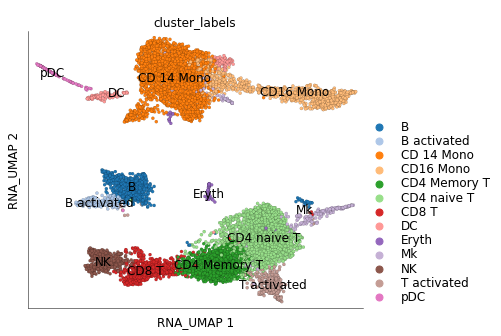

In [4]:
# Interferon beta stimulated PBMC data
ds_stim = scarf.DataStore(
    'scarf_datasets/kang_14K_ifnb-pbmc_rnaseq/data.zarr',
    nthreads=4
)

ds_stim.plot_layout(
    layout_key='RNA_UMAP',
    color_by='cluster_labels'
)

#### K-Nearest Neighbours (KNN) mapping


In [5]:


ds_ctrl.run_mapping(
    target_assay=ds_stim.RNA,
    target_name='stim',
    target_feat_key='hvgs_ctrl',
    save_k=5, 
    run_coral=True
)

INFO: 0 features missing in target data


Normalizing with feature subset:   0%|                                                                        …

(RNA) Writing aligned data to normed__I__hvgs_ctrl:   0%|                                                     …

INFO: Using existing normalized data with cell key I and feat key I__hvgs
INFO: Using existing loadings for pca with 25 dims
INFO: Using existing ANN index
INFO: using existing kmeans cluster centers
INFO: KNN graph already exists will not recompute.


CORAL: Computing source feature means:   0%|                                                                  …

CORAL: Computing source feature stdev:   0%|                                                                  …

CORAL: Computing target feature means:   0%|                                                                  …

CORAL: Computing target feature stdev:   0%|                                                                  …

CORAL: Computing source covariance:   0%|                                                                     …

CORAL: Computing target covariance:   0%|                                                                     …

INFO: Calculating fractional power of covariance matrices. This might take a while... 
INFO: Fractional power calculation complete


Writing out coral corrected data:   0%|                                                                       …

Mapping cells from stim:   0%|                                                                                …

#### Mapping scores

Target cluster CD 14 Mono


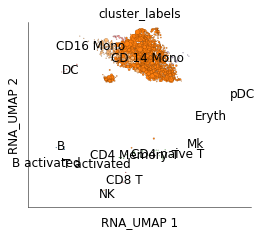

Target cluster NK


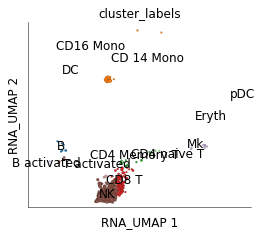

In [6]:
# plots for IFB-B stimulated cells from NK  and CD14 monocyte clusters.

for g, ms in ds_ctrl.get_mapping_score(
    target_name='stim',
    target_groups=ds_stim.cells.fetch('cluster_labels'),
    log_transform=True
):
    
    if g in ['NK', 'CD 14 Mono']:
        print (f"Target cluster {g}")
        ds_ctrl.plot_layout(
            layout_key='RNA_UMAP',
            color_by='cluster_labels',
            size_vals=ms*10,
            height=4, 
            width=4,
            legend_onside=False
        )

#### Label transfer

In [7]:
transferred_labels = ds_ctrl.get_target_classes(
    target_name='stim',
    reference_class_group='cluster_labels'
)

transferred_labels

0                  NK
1                 pDC
2         CD4 naive T
3                   B
4         CD4 naive T
             ...     
10106      CD 14 Mono
10107    CD4 Memory T
10108               B
10109      CD 14 Mono
10110     CD4 naive T
Length: 10111, dtype: object

In [8]:
ds_stim.cells.insert(
    'transferred_labels',
    transferred_labels.values,
    overwrite=True
)

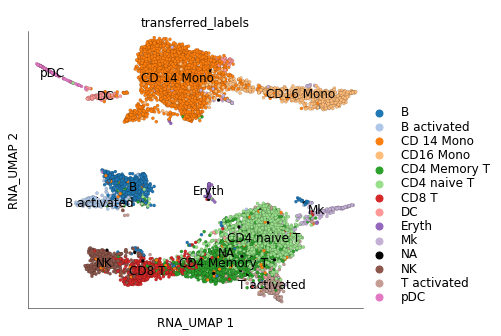

In [9]:
ds_stim.plot_layout(
    layout_key='RNA_UMAP',
    color_by='transferred_labels'
)

In [10]:
import pandas as pd

df = pd.crosstab(
    ds_stim.cells.fetch('cluster_labels'),
    ds_stim.cells.fetch('transferred_labels')
)
df

col_0,B,B activated,CD 14 Mono,CD16 Mono,CD4 Memory T,CD4 naive T,CD8 T,DC,Eryth,Mk,NA,NK,T activated,pDC
row_0,,,,,,,,,,,,,,
B,649,26,19,0,15,20,0,1,0,4,3,1,6,2
B activated,24,171,3,0,1,2,1,0,0,0,2,1,0,0
CD 14 Mono,0,0,2381,132,3,1,0,7,0,6,2,0,0,0
CD16 Mono,1,0,230,717,0,0,0,1,0,7,0,0,0,0
CD4 Memory T,5,0,45,1,923,217,72,0,1,5,18,0,10,0
CD4 naive T,14,4,36,0,356,1896,16,2,1,16,19,2,28,0
CD8 T,10,0,23,0,59,14,461,0,0,2,5,76,5,0
DC,0,0,73,4,0,0,0,137,0,0,0,0,0,0
Eryth,0,0,11,0,1,23,1,0,46,0,1,0,0,0


In [11]:
(100 * df / df.sum(axis=0)).round(1)

col_0,B,B activated,CD 14 Mono,CD16 Mono,CD4 Memory T,CD4 naive T,CD8 T,DC,Eryth,Mk,NA,NK,T activated,pDC
row_0,,,,,,,,,,,,,,
B,91.8,12.9,0.7,0.0,1.1,0.9,0.0,0.6,0.0,2.1,5.9,0.2,2.2,2.9
B activated,3.4,84.7,0.1,0.0,0.1,0.1,0.2,0.0,0.0,0.0,3.9,0.2,0.0,0.0
CD 14 Mono,0.0,0.0,82.6,15.4,0.2,0.0,0.0,4.5,0.0,3.1,3.9,0.0,0.0,0.0
CD16 Mono,0.1,0.0,8.0,83.9,0.0,0.0,0.0,0.6,0.0,3.6,0.0,0.0,0.0,0.0
CD4 Memory T,0.7,0.0,1.6,0.1,65.4,9.8,12.2,0.0,2.0,2.6,35.3,0.0,3.7,0.0
CD4 naive T,2.0,2.0,1.2,0.0,25.2,85.3,2.7,1.3,2.0,8.3,37.3,0.4,10.5,0.0
CD8 T,1.4,0.0,0.8,0.0,4.2,0.6,78.1,0.0,0.0,1.0,9.8,16.6,1.9,0.0
DC,0.0,0.0,2.5,0.5,0.0,0.0,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0
Eryth,0.0,0.0,0.4,0.0,0.1,1.0,0.2,0.0,92.0,0.0,2.0,0.0,0.0,0.0


#### Unified UMAPs

In [12]:
ds_ctrl.run_unified_umap(
    target_names=['stim'],
    ini_embed_with='RNA_UMAP',
    target_weight=1,
    use_k=5,
    n_epochs=100
)

Training UMAP:   0%|                                                                                          …

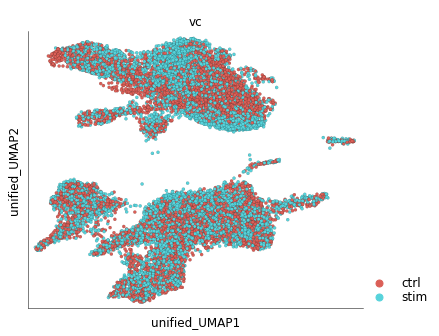

In [13]:
ds_ctrl.plot_unified_layout(
    layout_key='unified_UMAP',
    show_target_only=False,
    ref_name='ctrl'
)

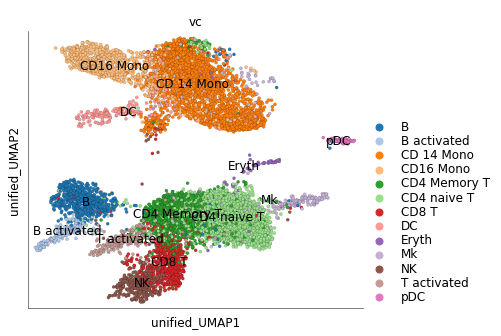

In [14]:
ds_ctrl.plot_unified_layout(
    layout_key='unified_UMAP',
    show_target_only=True, 
    legend_ondata=True,
    target_groups=ds_stim.cells.fetch('cluster_labels')
)